In [1]:
!pip install pypdfium2 backoff langchain-community langchain langchain-openai langgraph -q
!pip install qdrant-client -q


In [2]:
from io import BytesIO
import pypdfium2 as pdfium
import backoff
import asyncio
import json
import os
import base64
from PIL import Image
import operator

from typing import Annotated, Sequence, TypedDict, Literal

from openai import OpenAIError
from openai import AsyncOpenAI, OpenAI

from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import AnyMessage, BaseMessage, HumanMessage, SystemMessage
from langchain.tools.retriever import create_retriever_tool
from langchain_community.vectorstores import FAISS

from langgraph.graph.message import add_messages
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode


from IPython.display import Image, display
from pydantic import BaseModel, Field

In [3]:
# if you are working in colab
from google.colab import userdata
OPENAI_API_KEY= userdata.get('OPENAI_API_KEY')

In [4]:
MODEL = "gpt-4o-2024-08-06"
baseurl = "https://api.openai.com/v1"
apikey = OPENAI_API_KEY

clienta = AsyncOpenAI(api_key=apikey ,  base_url=baseurl)
os.environ["OPENAI_API_BASE"] = baseurl
os.environ["OPENAI_API_KEY"] = apikey

In [5]:
@backoff.on_exception(backoff.expo, OpenAIError)
async def parse_page_with_gpt(base64_image: str) -> str:
    messages=[
        {
            "role": "system",
            "content": """

            You are a helpful assistant that extracts information from images.

            """
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Extract information from image into text"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                        "detail": "auto"
                    },
                },
            ],
        }
    ]
    response = await clienta.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        max_tokens=4096,
    )
    return response.choices[0].message.content or ""

In [6]:
async def document_analysis(filename: str) -> str:
    """
    Document Understanding

    Args:
        filename: pdf filename str
    """

    pdf = pdfium.PdfDocument(filename)
    images = []
    for i in range(len(pdf)):
        page = pdf[i]
        image = page.render(scale=8).to_pil()
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        img_byte = buffered.getvalue()
        img_base64 = base64.b64encode(img_byte).decode("utf-8")
        images.append(img_base64)

    text_of_pages = await asyncio.gather(*[parse_page_with_gpt(image) for image in images])

    results = []

    extracted_texts = [doc for doc in text_of_pages]
    # Clean each string in the list and append to json_results
    for text in extracted_texts:
        results.append(text)

    return results

In [7]:
docs_list = await document_analysis("/content/stock price LSTM- GNN.pdf")

In [ ]:
docs_list

In [9]:
import uuid

output_file_path = f"{uuid.uuid4()}.txt"

with open(output_file_path, 'w') as json_file:
    json.dump(docs_list, json_file, indent=2)

print(f"data has been written to {output_file_path}")

data has been written to 1a982e27-8794-46c1-bf1e-ad89ec5d3f05.txt


In [10]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(output_file_path)
data = loader.load()
data

[Document(metadata={'source': '1a982e27-8794-46c1-bf1e-ad89ec5d3f05.txt'}, page_content='[\n  "**Title:** Stock Price Prediction Using a Hybrid LSTM-GNN Model: Integrating Time-Series and Graph-Based Analysis\\n\\n**Authors:**\\n- Meet Satishbhai Sonani, Department of Computer Science, University of Reading, UK\\n- Atta Badii, Department of Computer Science, University of Reading, UK\\n- Armin Moin, Department of Computer Science, University of Colorado, Colorado Springs, CO, USA\\n\\n**Abstract:**\\nThis paper presents a novel hybrid model that integrates long-short-term memory (LSTM) networks and Graph Neural Networks (GNNs) to enhance stock market prediction accuracy. The LSTM component captures temporal patterns in stock price data, while the GNN component uses Pearson correlation and association analysis to model inter-stock relational data. The model is trained using an expanding window validation approach. Experiments show that the hybrid model achieves a mean square error (MSE)

In [11]:
# Check if the file exists
if os.path.exists(output_file_path):

    # Delete the file
    os.remove(output_file_path)
    print(f"File {output_file_path} deleted successfully.")
else:
    print("File does not exist.")

File 1a982e27-8794-46c1-bf1e-ad89ec5d3f05.txt deleted successfully.


In [21]:
from langchain_core.documents import Document
from langchain_text_splitters import CharacterTextSplitter

documents = [Document(page_content=text, metadata={"page": i})
             for i, text in enumerate(docs_list)]

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=400)
doc_splits = text_splitter.split_documents(documents)
len(doc_splits)

50

In [14]:
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

In [38]:
from google.colab import userdata
QDRANT_API_KEY= userdata.get('QDRANT_API_KEY')
QDRANT_URL=""
QDRANT_API_KEY=""

In [39]:
import qdrant_client
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

client = QdrantClient(
    QDRANT_URL,
    api_key = QDRANT_API_KEY
)

QDRANT_COLLECTION = "agentic_collection"
collection_config = qdrant_client.http.models.VectorParams(
        size=1536, # 768 for instructor-xl, 1536 for OpenAI # 384 for sentence trans= fastembed 768 for mpnet
        distance=qdrant_client.http.models.Distance.COSINE
    )
client.recreate_collection(
    collection_name = QDRANT_COLLECTION,
    vectors_config=collection_config
)

/tmp/ipython-input-3990674477.py:17: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [40]:
from langchain.vectorstores import Qdrant

vectorstore = Qdrant(
        client=client,
        collection_name=QDRANT_COLLECTION,
        embeddings=embedding_model
    )
texts = [doc.page_content for doc in doc_splits]
vectorstore.add_texts(texts)
retriever=vectorstore.as_retriever()

In [25]:
retriever_tool = create_retriever_tool(
    retriever,
    "document_understanding",
    "Retrieve and provide insights on document content analysis and knowledge extraction",
)
tools = [retriever_tool]

In [26]:
class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [27]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)


    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) then grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    print("question: ", question)
    print("context: ", docs)
    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [28]:
### Nodes
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    print("context: ", docs)
    print("question: ", question)
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like


********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [29]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()


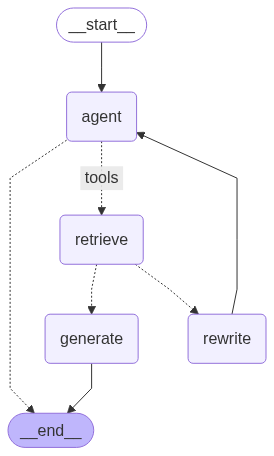

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
import pprint

inputs = {
    "messages": [
        ("user", """
        How is the graph constructed for the GNN component, and what metrics are used to define relationships between stocks?
        """),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_orodPM8UEjVSn7vR8uGQ2g2B', 'function': {'arguments': '{"query": "graph construction for GNN component in stock analysis"}', 'name': 'document_understanding'}, 'type': 'function'}, {'index': 1, 'id': 'call_w2YvW3VYPvUg5IWY0C9C1gvn', 'function': {'arguments': '{"query": "metrics used to define relationships between stocks in GNN"}', 'name': 'document_understanding'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'service_tier': 'default'}, id='run--6d4ebeb9-60b9-4ce5-88a9-a11abeaa01a5-0', tool_calls=[{'name': 'document_understanding', 'args': {'query': 'graph construction for GNN component in stock analysis'}, 'id': 'call_orodPM8UEjVSn7vR8uGQ2g2B', 'type': 'tool_call'}, {'name': 'document_understanding', 'args': {'query': 'metrics used to defi

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'The graph for the GNN component is constructed with nodes '
                'representing stocks and edges representing relationships '
                'between them. These relationships are defined using Pearson '
                'correlation coefficients to capture linear relationships and '
                'association analysis to identify non-linear and complex '
                'relationships. This combination provides a comprehensive '
                'representation of inter-stock relationships.']}
'\n---\n'


In [31]:
import pprint

inputs = {
    "messages": [
        ("user", """
        who is MSE of CNN in the figure 5 ?
        """),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_wtkFsHQ6KTgihfM7xWJpvdBX', 'function': {'arguments': '{"query":"MSE of CNN in figure 5"}', 'name': 'document_understanding'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'service_tier': 'default'}, id='run--6fb0406c-431a-470f-91c4-eed77a92487b-0', tool_calls=[{'name': 'document_understanding', 'args': {'query': 'MSE of CNN in figure 5'}, 'id': 'call_wtkFsHQ6KTgihfM7xWJpvdBX', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
question:  
        who is MSE of CNN in the figure 5 ?
        
context:  **Heatmap Information:**

- **Title:** MSE Heatmap for Models and Stocks
- **Models:** Dense, CNN, Middle, LSTM, LSTM+GNN
- **Stocks:** AAPL, MSFT, CMCSA, COST, QCOM, ADBE, SBUX, NTU, AMD, INTC
- **Color Scale:** Ranges from 0.001 to 0.00

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{'messages': ['The MSE of CNN in Figure 5 is 0.00302.']}
'\n---\n'


In [37]:
import pprint

inputs = {
    "messages": [
        ("user", """
        what could be the number of test day corresponding to the highest MSE value in figure 4?
        """),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_AvQ7tFlDQbNbkBYhyQ0HSJj3', 'function': {'arguments': '{"query":"highest MSE value in figure 4"}', 'name': 'document_understanding'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'service_tier': 'default'}, id='run--605026a7-2674-4317-b3b4-8374b0e06729-0', tool_calls=[{'name': 'document_understanding', 'args': {'query': 'highest MSE value in figure 4'}, 'id': 'call_AvQ7tFlDQbNbkBYhyQ0HSJj3', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
question:  
        what could be the number of test day corresponding to the highest MSE value in figure 4?
        
context:  - **Evaluation Metric**: Mean Squared Error (MSE) defined as:

  \[
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2
  \]

  where \( n \) is the number of pr